# **FRLC-style Optimal Transport using OTT-JAX**

In this tutorial, we reproduce the core idea of **FRLC (Factor Relaxation with Latent Coupling)**  
using standard building blocks from the [OTT-JAX library](https://ott-jax.readthedocs.io/).  
Rather than solving a full transport problem between all source and target points,  
we coarsen the transport via latent clusters.

We factorize the transport plan as:  
$$\hat{\mathbf{P}} = Q \cdot T \cdot R^\top$$  
where:
- `Q`: soft coupling from source to latent source clusters  
- `R`: soft coupling from target to latent target clusters  
- `T`: coupling between the two latent cluster sets

We compare this approach with standard Sinkhorn OT and its low-rank variant (Sinkhorn LR).

> 📄 This approach is inspired by the paper  
> **[Low-Rank Optimal Transport through Factor Relaxation with Latent Coupling](https://neurips.cc/virtual/2024/poster/94081)**  
> presented at NeurIPS 2024.

In [2]:
# Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

import torch
from torchdyn.datasets import generate_moons
from sklearn.cluster import KMeans

from ott.geometry import pointcloud, low_rank, costs
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## 1. Generate synthetic datasets: 8-Gaussians and 2-Moons

In [3]:
import torch
from torchdyn.datasets import generate_moons
import math

In [4]:
def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1

In [5]:
def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.MultivariateNormal(torch.zeros(dim), math.sqrt(var) * torch.eye(dim))
    centers = torch.tensor([
        (1, 0), (-1, 0), (0, 1), (0, -1),
        (1/np.sqrt(2), 1/np.sqrt(2)), (1/np.sqrt(2), -1/np.sqrt(2)),
        (-1/np.sqrt(2), 1/np.sqrt(2)), (-1/np.sqrt(2), -1/np.sqrt(2))
    ]) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = torch.stack([centers[multi[i]] + noise[i] for i in range(n)])
    return data



In [6]:
def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


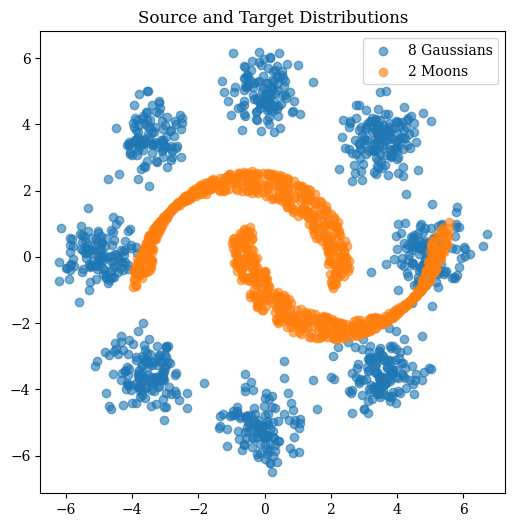

In [7]:
n = 1000
x0 = sample_8gaussians(n).numpy()
x1 = sample_moons(n).numpy()

plt.figure(figsize=(6, 6))
plt.scatter(x0[:, 0], x0[:, 1], label="8 Gaussians", alpha=0.6)
plt.scatter(x1[:, 0], x1[:, 1], label="2 Moons", alpha=0.6)
plt.legend()
plt.title("Source and Target Distributions")
plt.axis("equal")
plt.show()


## 2. Solve classical OT using Sinkhorn

In [8]:
# Convert to JAX arrays and define uniform weights
x0_jax = jnp.array(x0)
x1_jax = jnp.array(x1)
a = jnp.ones((n,)) / n
b = jnp.ones((n,)) / n

In [9]:
geom = pointcloud.PointCloud(x0_jax, x1_jax)

problem = linear_problem.LinearProblem(geom, a=a, b=b)
solver = sinkhorn.Sinkhorn()
out = solver(problem)

print(f"OT cost (Sinkhorn): {out.reg_ot_cost:.4f}")

OT cost (Sinkhorn): 10.7260


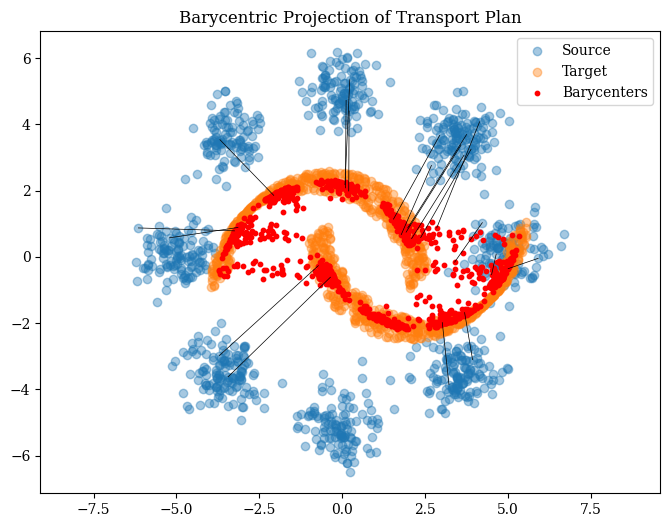

In [10]:
plan = out.matrix
barycenters = (plan @ x1_jax) / jnp.sum(plan, axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
plt.scatter(x0_jax[:, 0], x0_jax[:, 1], label="Source", alpha=0.4)
plt.scatter(x1_jax[:, 0], x1_jax[:, 1], label="Target", alpha=0.4)
plt.scatter(barycenters[:, 0], barycenters[:, 1], color="red", label="Barycenters", s=10)

# Draw transport arrows
for i in range(0, n, 50):
    plt.plot([x0_jax[i, 0], barycenters[i, 0]], [x0_jax[i, 1], barycenters[i, 1]], 'k-', linewidth=0.5)

plt.legend()
plt.title("Barycentric Projection of Transport Plan")
plt.axis("equal")
plt.show()

**Interpretation**: The red points represent barycenters of the transport from source to target.
Notice how they follow the two-moons shape, showing that Sinkhorn aligns the source points toward the moon structure while preserving local geometry.

## 3. Solve OT using Sinkhorn with low-rank geometry
#### Build cost matrix and factor it using randomized SVD

In [11]:
from ott.geometry.low_rank import LRCGeometry
from sklearn.utils.extmath import randomized_svd

# Compute and normalize the cost matrix
cost_matrix = jnp.sum(x0_jax**2, axis=1)[:, None] + jnp.sum(x1_jax**2, axis=1)[None, :] - 2 * jnp.dot(x0_jax, x1_jax.T)
cost_matrix = cost_matrix / jnp.max(cost_matrix)

# Factorize the cost matrix with randomized SVD
cost_np = np.array(cost_matrix)
U, S, Vt = randomized_svd(cost_np, n_components=50, n_iter=5, random_state=42)
cost_1 = jnp.array(U @ np.diag(np.sqrt(S)))
cost_2 = jnp.array(Vt.T @ np.diag(np.sqrt(S)))

# Now construct the low-rank geometry
geom_lr = LRCGeometry(cost_1=cost_1, cost_2=cost_2, epsilon=0.05)

# Solve the OT problem
prob_lr = linear_problem.LinearProblem(geom_lr, a=a, b=b)
solver = sinkhorn.Sinkhorn()
out_lr = solver(prob_lr)

print(f"Sinkhorn LR OT cost (LRCGeometry): {out_lr.reg_ot_cost:.4f}")

Sinkhorn LR OT cost (LRCGeometry): 0.1303


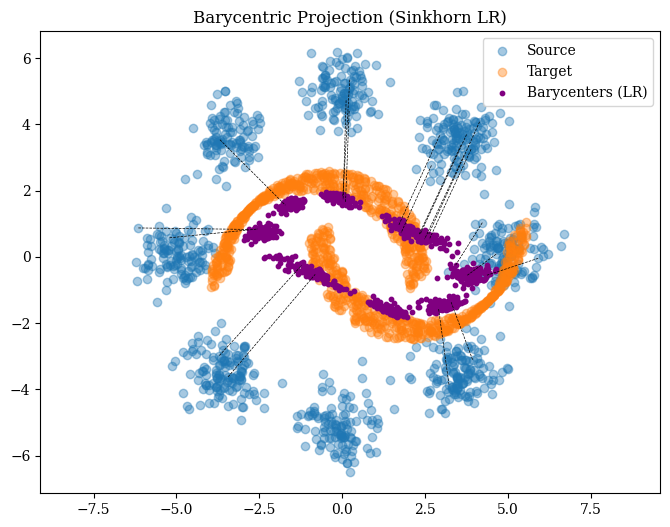

In [12]:
# Visualize barycenters from LR
plan_lr = out_lr.matrix
bary_lr = (plan_lr @ x1_jax) / jnp.sum(plan_lr, axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
plt.scatter(x0[:, 0], x0[:, 1], label="Source", alpha=0.4)
plt.scatter(x1[:, 0], x1[:, 1], label="Target", alpha=0.4)
plt.scatter(bary_lr[:, 0], bary_lr[:, 1], color="purple", label="Barycenters (LR)", s=10)
for i in range(0, n, 50):
    plt.plot([x0[i, 0], bary_lr[i, 0]], [x0[i, 1], bary_lr[i, 1]], 'k--', linewidth=0.5)
plt.legend()
plt.title("Barycentric Projection (Sinkhorn LR)")
plt.axis("equal")
plt.show()

**Interpretation**: The purple barycenters are more diffused compared to full Sinkhorn.
This reflects the approximation introduced by the low-rank kernel: faster computation but lower precision, especially in densely curved regions like the moons' inner arc.

## 4. FRLC-style approximation using latent clusters and factorized transport

This section reproduces the conceptual mechanism behind FRLC by using a three-stage OT decomposition.  
First, the source and target point clouds are compressed via KMeans clustering into `r` latent clusters each.  
Then, we solve three separate optimal transport problems:
- `Q`: between the original source points and their latent centroids `z_Q`
- `R`: between the target points and their latent centroids `z_R`
- `T`: between the latent clusters `z_Q` and `z_R`

By composing these three transport plans as `Q @ T @ R.T`, we reconstruct an approximate transport matrix  
between the source and target supports. This mirrors the structure introduced in the FRLC paper,  
where transport is relaxed through a latent bottleneck for improved interpretability and scalability.

In [13]:
r = 30
kmeans_src = KMeans(n_clusters=r, n_init=10).fit(x0)
kmeans_tgt = KMeans(n_clusters=r, n_init=10).fit(x1)

z_Q = jnp.array(kmeans_src.cluster_centers_)
z_R = jnp.array(kmeans_tgt.cluster_centers_)
a_latent = jnp.ones((r,)) / r

In [14]:
# Solve Q: OT between source and latent Q
geom_Q = pointcloud.PointCloud(x0_jax, z_Q)
out_Q = solver(linear_problem.LinearProblem(geom_Q, a=a, b=a_latent))
Q = out_Q.matrix

# Solve R: OT between target and latent R
geom_R = pointcloud.PointCloud(x1_jax, z_R)
out_R = solver(linear_problem.LinearProblem(geom_R, a=b, b=a_latent))
R = out_R.matrix

# Solve T: OT between latent clusters
geom_T = pointcloud.PointCloud(z_Q, z_R)
out_T = solver(linear_problem.LinearProblem(geom_T, a=a_latent, b=a_latent))
T = out_T.matrix

# Reconstruct full plan
P_approx = Q @ T @ R.T

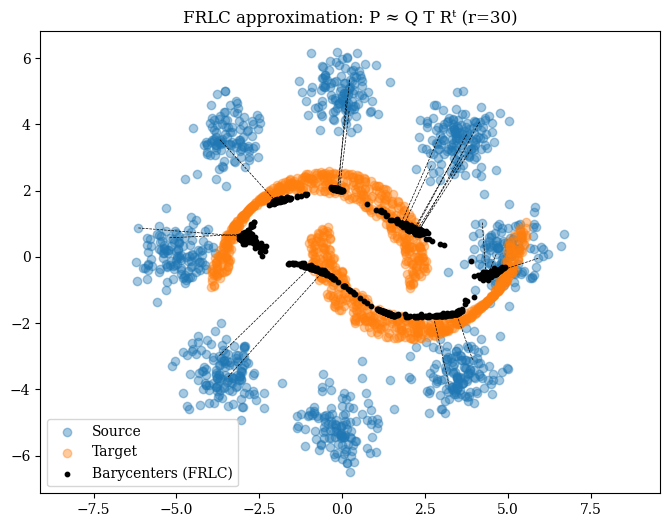

In [16]:
# Visualize barycenters from FRLC
bary_frlc = (P_approx @ x1_jax) / jnp.sum(P_approx, axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
plt.scatter(x0[:, 0], x0[:, 1], label="Source", alpha=0.4)
plt.scatter(x1[:, 0], x1[:, 1], label="Target", alpha=0.4)
plt.scatter(bary_frlc[:, 0], bary_frlc[:, 1], color="black", label="Barycenters (FRLC)", s=10)
for i in range(0, n, 50):
    plt.plot([x0[i, 0], bary_frlc[i, 0]], [x0[i, 1], bary_frlc[i, 1]], 'k--', linewidth=0.5)
plt.legend()
plt.title(f"FRLC approximation: P ≈ Q T Rᵗ (r={r})")
plt.axis("equal")
plt.show()


**Interpretation**: The FRLC barycenters (black) reflect a smoothed, latent-level matching between distributions.

**Compared to the full OT plan, these barycenters are more regular and tend to reflect the centroids of latent alignment, providing interpretability and computational benefits.**

---
END